<a href="https://colab.research.google.com/github/astrapi69/DroidBallet/blob/master/NLP_D3_4_L1_NLP_Applications_Text_Classification_Deep_Learning_CNN_Models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<center><a target="_blank" href="https://academy.constructor.org/"><img src="https://jobtracker.ai/static/media/constructor_academy_colour.b86fa87f.png" width="200" style="background:none; border:none; box-shadow:none;" /></a> </center>

_____


<center>Constructor Academy, 2024</center>

# Text Classification - Deep Learning CNN Models



<img src="https://github.com/dipanjanS/nlp_workshop_dhs18/blob/master/Unit%2012%20-%20Project%209%20-%20Sentiment%20Analysis%20-%20Supervised%20Learning/banner.jpeg?raw=1">

When it comes to text data, sentiment analysis is one of the most widely performed analysis on it. Sentiment Analysis has been through tremendous improvements from the days of classic methods to recent times where in the state of the art models utilize deep learning to improve the performance.

Convolutional Neural Networks or CNNs are the work-horse of the deep learning world. They have, in some sense, brought deep learning research into mainstream discussions. The advancements in the image classification world has left even humans behind.

<img src="https://i.imgur.com/zlmXpr9.png">


In this project, we will attempt at performing sentiment analysis utilizing the power of CNNs.

In [ ]:
!pip install contractions
!pip install textsearch
!pip install tqdm
import nltk
nltk.download('punkt')

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.9/289.9 kB 5.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.7/110.7 kB 6.8 MB/s eta 0:00:00


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
import pandas as pd
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Conv1D
from tensorflow.keras.layers import MaxPooling1D
from tensorflow.keras.layers import Embedding
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing import sequence
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf

# fix random seed for reproducibility
seed = 42
np.random.seed(seed)

## Load Movie Review Dataset

In [ ]:
dataset = pd.read_csv(r'https://github.com/dipanjanS/nlp_workshop_dhs18/raw/master/Unit%2011%20-%20Sentiment%20Analysis%20-%20Unsupervised%20Learning/movie_reviews.csv.bz2', compression='bz2')
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  object
dtypes: object(2)
memory usage: 781.4+ KB


In [ ]:
# take a peek at the data
dataset.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


### Prepare Train Test Split

In [ ]:
# build train and test datasets
reviews = dataset['review'].values
sentiments = dataset['sentiment'].values

train_reviews = reviews[:35000]
train_sentiments = sentiments[:35000]

test_reviews = reviews[35000:]
test_sentiments = sentiments[35000:]

In [ ]:
train_reviews.shape, test_reviews.shape

((35000,), (15000,))

## Text Wrangling & Normalization

In [ ]:
import contractions
from bs4 import BeautifulSoup
import numpy as np
import re
import tqdm
import unicodedata


def strip_html_tags(text):
  soup = BeautifulSoup(text, "html.parser")
  [s.extract() for s in soup(['iframe', 'script'])]
  stripped_text = soup.get_text()
  stripped_text = re.sub(r'[\r|\n|\r\n]+', '\n', stripped_text)
  return stripped_text

def remove_accented_chars(text):
  text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')
  return text

def pre_process_corpus(docs):
  norm_docs = []
  for doc in tqdm.tqdm(docs):
    # remove html
    doc = strip_html_tags(doc)
    # remove extra newline \ tabs
    doc = doc.translate(doc.maketrans("\n\t\r", "   "))
    # lower casing
    doc = doc.lower()
    # removing accents
    doc = remove_accented_chars(doc)
    # fixing contractions don't -> do not
    doc = contractions.fix(doc)
    # remove special characters\whitespaces
    doc = re.sub(r'[^a-zA-Z0-9\s]', '', doc, flags=re.I|re.A)
    doc = re.sub(' +', ' ', doc) # how    are  you -> how are you
    doc = doc.strip()
    norm_docs.append(doc)

  return norm_docs

In [ ]:
%%time

norm_train_reviews = pre_process_corpus(train_reviews)
norm_test_reviews = pre_process_corpus(test_reviews)

  2%|▏         | 639/35000 [00:00<00:16, 2074.07it/s]<ipython-input-7-107989a88111>:10: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  soup = BeautifulSoup(text, "html.parser")
100%|██████████| 15000/15000 [00:07<00:00, 2120.48it/s]

CPU times: user 24.6 s, sys: 175 ms, total: 24.8 s
Wall time: 25.1 s


### Preprocessing

To prepare text data for our deep learning model, we transform each review into a sequence.
Every word in the review is mapped to an integer index and thus the sentence turns into a sequence of numbers.

To perform this transformation, keras provides the ```Tokenizer```

```

max_sequence_length = 8

training vocabulary includes words ['the', 'movie', 'is', 'from', ...., and more...] (but NOT 'south' and 'china')

'the movie is from south china'

<UNK> 1
<PAD> 0

[2, 45, 23, 67, 1, 1, 0, 0 ]


0 [embedding repr for PAD token]
1 [embedding repr for the UNK token]
```

In [ ]:
norm_train_reviews[:3]

['one of the other reviewers has mentioned that after watching just 1 oz episode you will be hooked they are right as this is exactly what happened with methe first thing that struck me about oz was its brutality and unflinching scenes of violence which set in right from the word go trust me this is not a show for the faint hearted or timid this show pulls no punches with regards to drugs sex or violence its is hardcore in the classic use of the wordit is called oz as that is the nickname given to the oswald maximum security state penitentary it focuses mainly on emerald city an experimental section of the prison where all the cells have glass fronts and face inwards so privacy is not high on the agenda them city is home to manyaryans muslims gangstas latinos christians italians irish and moreso scuffles death stares dodgy dealings and shady agreements are never far awayi would say the main appeal of the show is due to the fact that it goes where other shows would not dare forget prett

In [ ]:
t = Tokenizer(oov_token='<UNK>')
# fit the tokenizer on the documents to create the vocabulary of unique words and map them to row numbers in the embedding layer
t.fit_on_texts(norm_train_reviews)

In [ ]:
t.word_index['<PAD>'] = 0

In [ ]:
max([(k, v) for k, v in t.word_index.items()], key = lambda x:x[1])

('dawgis', 175812)

In [ ]:
min([(k, v) for k, v in t.word_index.items()], key = lambda x:x[1])

('<PAD>', 0)

```
s = 'the avengers was great'
r = t.texts_to_sequences([s])
[4, 55, 123, 11]
```

In [ ]:
s = ['the avengers was really great',
     'the avengers bad']
r = t.texts_to_sequences(s)
r

[[2, 15984, 14, 63, 84], [2, 15984, 83]]

In [ ]:
train_sequences = t.texts_to_sequences(norm_train_reviews)

In [ ]:
test_sequences = t.texts_to_sequences(norm_test_reviews)

In [ ]:
print("Vocabulary size={}".format(len(t.word_index)))
print("Number of Documents={}".format(t.document_count))

Vocabulary size=175813
Number of Documents=35000


In [ ]:
[len(review) for review in train_sequences[:3]]

[308, 156, 164]

In [ ]:
max([len(sentence_tokens) for sentence_tokens in train_sequences])

2463

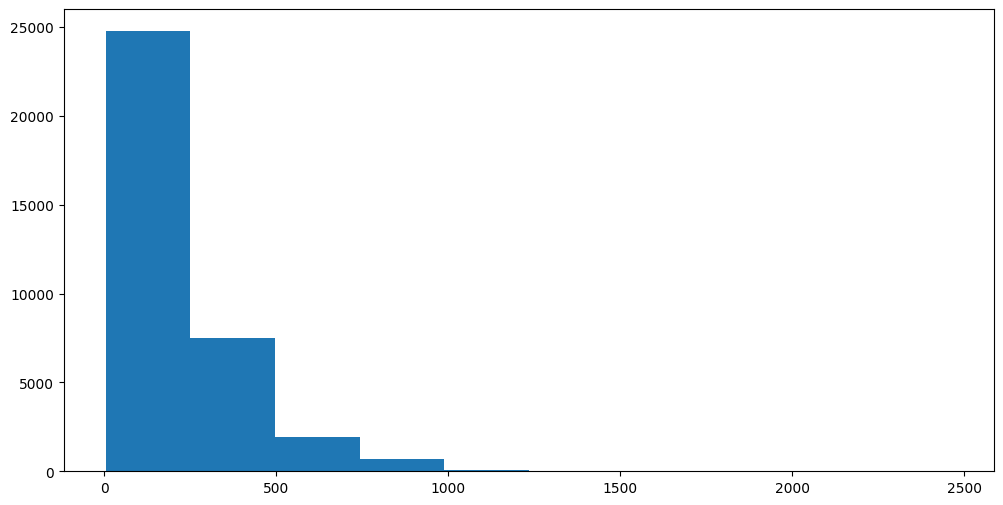

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

train_lens = [len(s) for s in train_sequences]

fig, ax = plt.subplots(1,1, figsize=(12, 6))
h1 = ax.hist(train_lens)

### Sequence Normalization

Not all reviews are of same length. To handle this difference in length of reviews, we define a maximum length.
For reviews which are smaller than this length, we pad them with zeros which longer ones are truncated

In [ ]:
MAX_SEQUENCE_LENGTH = 1000

In [ ]:
# pad dataset to a maximum review length in words
X_train = sequence.pad_sequences(train_sequences, maxlen=MAX_SEQUENCE_LENGTH, padding='post')
X_test = sequence.pad_sequences(test_sequences, maxlen=MAX_SEQUENCE_LENGTH,  padding='post')
X_train.shape, X_test.shape

((35000, 1000), (15000, 1000))

### Encoding Labels

The dataset contains labels of the form positive/negative. The following step encodes the labels using ```sklearn's``` ```LabelEncoder```

In [ ]:
le = LabelEncoder()
num_classes=2 # positive -> 1, negative -> 0

In [ ]:
y_train = le.fit_transform(train_sentiments)
y_test = le.transform(test_sentiments)

In [ ]:
VOCAB_SIZE = len(t.word_index)
VOCAB_SIZE

175813

In [ ]:
train_sentiments[:10]

array(['positive', 'positive', 'positive', 'negative', 'positive',
       'positive', 'positive', 'negative', 'negative', 'positive'],
      dtype=object)

In [ ]:
y_train[:10]

array([1, 1, 1, 0, 1, 1, 1, 0, 0, 1])

## Prepare the Model

Since textual data is a sequence of words, we utilize ```1D``` convolutions to scan through the sentences.
The model first transforms each word into lower dimensional embedding/vector space followed by 1d convolutions and then passing the data through dense layers before the final layer for classification

### Embeddings

The Embedding layer helps us generate the word embeddings from scratch. This layer
is also initialized with some weights and is updated based on our optimizer, similar to
weights on the neuron units in other layers when the network tries to minimize the loss
in each epoch. Thus, the embedding layer tries to optimize its weights such that we get
the best word embeddings that will generate minimum error in the model and capture
semantic similarity and relationships among words. How do we get the embeddings?
Let’s say we have a review with three terms ['movie', 'was', 'good'] and a vocab_map
consisting of word to index mappings for 175860 words.

![](https://i.imgur.com/wOPsWof.png)

In [ ]:
EMBED_SIZE = 300 # word embedding size
EPOCHS=10
BATCH_SIZE=128

In [ ]:
VOCAB_SIZE # the unique number of words in our training data where each word will have a word embedding of size 300

175813

![](https://i.imgur.com/XRaoZRW.png)

In [ ]:
# create the model
model = Sequential()

# embedding layer is of dim: 175813 x 300
model.add(Embedding(VOCAB_SIZE,
                    EMBED_SIZE,
                    input_length=MAX_SEQUENCE_LENGTH))

model.add(Conv1D(filters=128, kernel_size=4, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))

model.add(Conv1D(filters=64, kernel_size=4, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))

model.add(Conv1D(filters=32, kernel_size=4, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))

model.add(Flatten())

model.add(Dense(256, activation='relu'))

model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 1000, 300)         52743900  
                                                                 
 conv1d (Conv1D)             (None, 1000, 128)         153728    
                                                                 
 max_pooling1d (MaxPooling1  (None, 500, 128)          0         
 D)                                                              
                                                                 
 conv1d_1 (Conv1D)           (None, 500, 64)           32832     
                                                                 
 max_pooling1d_1 (MaxPoolin  (None, 250, 64)           0         
 g1D)                                                            
                                                                 
 conv1d_2 (Conv1D)           (None, 250, 32)           8

## Model Training

In [ ]:
# callbacks
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                      patience=2,
                                      restore_best_weights=True,
                                      verbose=1)

# Fit the model
model.fit(X_train, y_train,
          validation_split=0.1,
          epochs=EPOCHS,
          batch_size=BATCH_SIZE,
          callbacks=[es],
          verbose=1)

Epoch 1/10
247/247 [==============================] - 57s 202ms/step - loss: 0.3861 - accuracy: 0.7969 - val_loss: 0.2404 - val_accuracy: 0.9080
Epoch 2/10
247/247 [==============================] - 41s 166ms/step - loss: 0.1203 - accuracy: 0.9577 - val_loss: 0.3608 - val_accuracy: 0.8631
Epoch 3/10
247/247 [==============================] - 41s 165ms/step - loss: 0.0320 - accuracy: 0.9901 - val_loss: 0.4103 - val_accuracy: 0.8834
Epoch 3: early stopping


## Model Evaluation

In [ ]:
# Final evaluation of the model
scores = model.evaluate(X_test, y_test, verbose=1)
print("Accuracy: %.2f%%" % (scores[1]*100))

469/469 [==============================] - 4s 7ms/step - loss: 0.2420 - accuracy: 0.9037
Accuracy: 90.37%


In [ ]:
predict_probas = model.predict(X_test)
predict_probas[:5]

469/469 [==============================] - 3s 6ms/step


array([[0.08232854],
       [0.99581087],
       [0.00643875],
       [0.99513215],
       [0.9220497 ]], dtype=float32)

In [ ]:
predict_probas = predict_probas.ravel()
predict_probas[:5]

array([0.08232854, 0.99581087, 0.00643875, 0.99513215, 0.9220497 ],
      dtype=float32)

In [ ]:
predictions = [1 if proba > 0.5 else 0 for proba in predict_probas]
predictions[:5]

[0, 1, 0, 1, 1]

In [ ]:
predictions = le.inverse_transform(predictions)
predictions[:5]

array(['negative', 'positive', 'negative', 'positive', 'positive'],
      dtype=object)

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report

labels = ['negative', 'positive']
print(classification_report(test_sentiments, predictions))
pd.DataFrame(confusion_matrix(test_sentiments, predictions), index=labels, columns=labels)

              precision    recall  f1-score   support

    negative       0.89      0.92      0.90      7490
    positive       0.91      0.89      0.90      7510

    accuracy                           0.90     15000
   macro avg       0.90      0.90      0.90     15000
weighted avg       0.90      0.90      0.90     15000



,negative,positive
negative,6860,630
positive,815,6695
